# Building a classifier for the clothing in FashionMNIST database


## Getting our data ready

Define our train and test data sets and dataloaders


In [8]:
import torch
import torchvision
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

batch_size = 4
mean = (0.5,)
std = (0.5,)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])


train_set = datasets.FashionMNIST(
    root="./data", download=True, train=True, transform=transform
)
test_set = datasets.FashionMNIST(
    root="./data", download=True, train=False, transform=transform
)

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

classes = (
    "T-shirt/top",  # 0
    "Trouser",  # 1
    "Pullover",  # 2
    "Dress",  # 3
    "Coat",  # 4
    "Sandal",  # 5
    "Shirt",  # 6
    "Sneaker",  # 7
    "Bag",  # 8
    "Ankle boot",  # 9
)

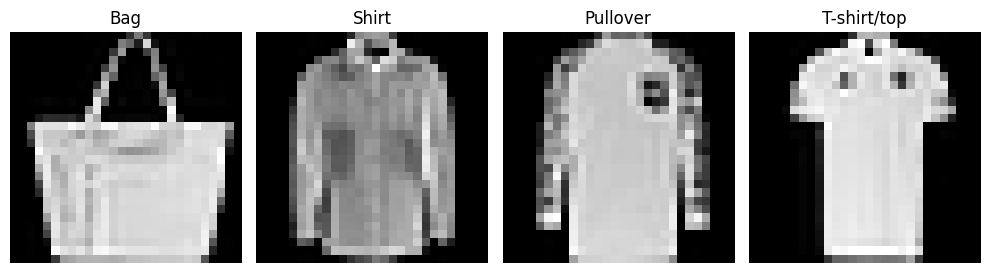

In [9]:
# Helper function for inline image display
def matplotlib_imshow(batch):
    # batch = [batch[0][0:5], batch[1][0:5]]
    fig, axes = plt.subplots(1, len(batch[0]), figsize=(10, 5))
    for idx, img in enumerate(batch[0]):
        ax = axes[idx]
        ax.imshow(img.squeeze(), cmap="gray")
        ax.axis("off")
        ax.set_title(classes[batch[1][idx]])

    plt.tight_layout()
    plt.show()


# Display the first batch only
for batch in train_dataloader:
    matplotlib_imshow(batch)
    break

## Create our Model


In [10]:
class FashionNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu = nn.ReLU()
        self.linear_stack = nn.Sequential(
            nn.Linear(16 * 4 * 4, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = nn.Flatten()(x)
        x = self.linear_stack(x)
        return x


# Define our model
model = FashionNet()

learning_rate = 0.001

# Define our criterion
criterion = nn.CrossEntropyLoss()

# Define our optimiser
optimiser = optim.SGD(model.parameters(), lr=learning_rate)

print(model)

FashionNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (linear_stack): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


## Train our Model


In [ ]:
def train_epoch(model, data_loader, loss_fn):
    for idx, batch in enumerate(data_loader):
        imgs, labels = batch[0], batch[1]

        # Set parameter gradients back to zero
        optimiser.zero_grad()

        # Forward pass
        output = model(imgs)

        # Calculate Loss
        loss = loss_fn(output, labels)

        # Back propagation
        loss.backward()

        # Update Parameters
        optimiser.step()

        if idx % 2000 == 0:
            print(f"Loss: {loss} | Batch: {idx}/{(len(data_loader)-1)}")


epochs = 5

model.train(True)

for epoch in range(epochs):
    print(f"\nEpoch {epoch}\n----------------")
    train_epoch(model=model, data_loader=train_dataloader, loss_fn=criterion)

## Save our model


In [15]:
torch.save(model.state_dict(), "FashionNet.pt")

## Evaluate our model's performance in a testing loop


In [20]:
model1 = FashionNet()
model1.load_state_dict(torch.load("FashionNet.pt"))
model1.eval()


def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )


test_loop(test_dataloader, model, criterion)

Test Error: 
 Accuracy: 88.6%, Avg loss: 0.309299 

